In [21]:
SALIENCY_DIR = '/data/amartyadutta/weight_unweight/'
MODEL_FLAG = 'original' # 'noisy'
# INPUT_FMT = 'crop_accumulate' ,'crop', 'mask', 'crop_mask'
size = 224
NUM_CROPS = 200
NUM_MASKS = 1
# if INPUT_FMT == 'crop_mask':
#     NUM_MASKS = 20
# else:
#     NUM_MASKS = 50

# SALIENCY_DIR = '/raid/maruf/WSS/SALIENCY/original/image_crop/'
# SALIENCY_DIR = '/raid/maruf/WSS/SALIENCY/original/image_binmask/'
# SALIENCY_DIR = '/raid/maruf/WSS/SALIENCY/original/image_binmask_crop/'

In [22]:
from __future__ import print_function
import os
import sys
sys.path.append('../../')
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from PIL import Image
import PIL
import numpy as np
import torch
import torch.optim
from torch.autograd import Variable
from torch import multiprocessing, cuda
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn
from torch.backends import cudnn
import seaborn as sns
import importlib
import os
from tqdm import tqdm
import voc12.dataloader
from misc import torchutils, imutils, myutils
import torchvision.transforms as transforms
from misc.myutils import unnormalize_image

In [23]:
GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '1,2,3,4'
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor

num GPUs 4


In [24]:
CLASSNAME_LIST = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
        'bottle', 'bus', 'car', 'cat', 'chair',
        'cow', 'diningtable', 'dog', 'horse',
        'motorbike', 'person', 'pottedplant',
        'sheep', 'sofa', 'train',
        'tvmonitor']

# Load Dataset

In [25]:
from chainercv.datasets import VOCSemanticSegmentationDataset
from chainercv.evaluations import calc_semantic_segmentation_confusion

# ground truth labels in gt_labels

gt_dataset = VOCSemanticSegmentationDataset(split="train",
                                            data_dir='/home/amartyadutta/VOC12/AMN/Datasets/VOCdevkit/VOC2012')

gt_labels = [gt_dataset.get_example_by_keys(i, (1,))[0] for i in range(len(gt_dataset))]


# segmentation dataset and data_loader 

dataset = voc12.dataloader.VOC12ClassificationDatasetMSF(img_name_list_path='/home/amartyadutta/VOC12/AMN/voc12/train.txt',
                                                         voc12_root='/home/amartyadutta/VOC12/AMN/Datasets/VOCdevkit/VOC2012', 
                                                         scales=(1.0,))

data_loader = DataLoader(dataset, shuffle=False)


# NDR gt corresponds to non-deterministic region ground truths

ndr_gt_labels = [np.load(os.path.join('/raid/maruf/WSS/NDR_ground_truth', id + '.npy'), allow_pickle=True) for id in gt_dataset.ids]


# Load Model

In [26]:
model = getattr(importlib.import_module('net.resnet50_cam'), 'CAM_original')()

if MODEL_FLAG == 'original':
    model.load_state_dict(torch.load('/home/maruf/ws2m2/sess/res50_cam_original_version.pth' + '.pth', map_location='cpu'), strict=True)

elif MODEL_FLAG == 'noisy':
    model.load_state_dict(torch.load('/home/maruf/ws2m2/sess/res50_cam_bin_noise_version.pth' + '.pth', map_location='cpu'), strict=True)
    
model.eval()

model = model.cuda()

# SALIENCY

In [27]:
from torch.utils.data import Dataset

class RandomCropDataset(Dataset):
    def __init__(self, tensor, transform, size=1):
        self.tensor = tensor.squeeze(0)
        self.transform = transform
        self.size = size
    
    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):
        return self.transform(self.tensor)

t = transforms.Compose([
        transforms.RandomResizedCrop(
            (size,size),
            scale=(0.05, 0.3), 
            ratio=(0.85, 1.25)
        )
    ])
    
def get_saliencies(
    img_tensor,
    target_class,
    input_fmt='img',
    transform=t,
    num_crops = 100,
    num_masks = 50
):
    
    
    if input_fmt == 'img':
        
        model.zero_grad()
        
        img_tensor.requires_grad = True

        scores = model(img_tensor.type(dtype))

        combined_saliencies = []

        for class_idx in target_class:

            target_score = scores[:, class_idx]

            saliency = torch.autograd.grad(
                target_score, img_tensor,
                grad_outputs = torch.ones_like(target_score),
                retain_graph = True
            )[0]

            saliency = saliency.detach().abs().max(1)[0]
            combined_saliencies.append(saliency)

        raw_saliency = torch.cat(combined_saliencies).detach()
        
        return raw_saliency
        
    elif input_fmt == 'crop':
        
        img_tensor.requires_grad = True
        
        dataset = RandomCropDataset(img_tensor, transform, size=num_crops)
        dataloader = DataLoader(dataset, batch_size=batch)

        _, _, H, W = img_tensor.shape
        num_classes = len(target_class)
        real_saliencies = torch.zeros(num_crops, num_classes, size, size).type(dtype)
        
        for batch in dataloader:
            model.zero_grad()
            out = model(batch.type(dtype))
        
            for i, label in enumerate(target_class):
                label = label.long()
                target_val = out[:,label]
                weights = torch.sigmoid(target_val)
                
                
                #Saliency
                saliency = torch.autograd.grad(
                                        target_val, batch, 
                                        grad_outputs=weights,
                                        retain_graph=True
                                    )[0]
            
                saliency = saliency.detach().abs().max(1)[0]
                real_saliencies[:,i] += saliency.type(dtype)
        
        
        return batch, real_saliencies
    
    elif input_fmt == 'w_crop_accumulate':
        
        img_tensor.requires_grad = True
        
        dataset = RandomCropDataset(img_tensor, transform, size=num_crops)
        dataloader = DataLoader(dataset, batch_size=100)

        _, _, H, W = img_tensor.shape
        num_classes = len(target_class)
        real_saliencies = torch.zeros(num_classes, 1, H, W).type(dtype)
        c=0
        for batch in dataloader:
            model.zero_grad()
            out = model(batch.type(dtype))
            print(c)
            for i, label in enumerate(target_class):
                label = label.long()
                target_val = out[:,label]
                weights = torch.sigmoid(target_val)

                # Weighted Saliency
                saliency = torch.autograd.grad(
                                        target_val, img_tensor, 
                                        grad_outputs=weights,
                                        retain_graph=True
                                    )[0]
                saliency = saliency.detach().abs().max(1)[0]
                real_saliencies[i] += saliency.type(dtype)
            c+=1
        raw_saliency = real_saliencies.squeeze(1).detach()
        
        return raw_saliency
    
    elif input_fmt == 'uw_crop_accumulate':
        
        img_tensor.requires_grad = True
        
        dataset = RandomCropDataset(img_tensor, transform, size=num_crops)
        dataloader = DataLoader(dataset, batch_size=100)

        _, _, H, W = img_tensor.shape
        num_classes = len(target_class)
        real_saliencies = torch.zeros(num_classes, 1, H, W).type(dtype)
        # c=0
        for batch in dataloader:
            model.zero_grad()
            out = model(batch.type(dtype))
            
            for i, label in enumerate(target_class):
                label = label.long()
                target_val = out[:,label]
                unweights = target_val/target_val
                # print(unweights)
                # Weighted Saliency
                saliency = torch.autograd.grad(
                                        target_val, img_tensor, 
                                        grad_outputs=unweights,
                                        retain_graph=True
                                    )[0]
                saliency = saliency.detach().abs().max(1)[0]
                real_saliencies[i] += saliency.type(dtype)
                # c+=1
        raw_saliency = real_saliencies.squeeze(1).detach()
        
        return raw_saliency
        
    elif input_fmt == 'mask':
        
        _, _, H, W = img_tensor.shape
        num_classes = len(target_class)
        agg_saliencies = torch.zeros(num_classes, H, W).type(dtype)
        
        for _ in range(num_masks):
            
            prob_mask = 0.9 * torch.ones(H, W)
            binary_mask = torch.bernoulli(prob_mask).detach()
            binary_mask.requires_grad = True
            
            noisy_img = img_tensor * binary_mask
            
            model.zero_grad()

            scores = model(noisy_img.type(dtype))

            combined_saliencies = []

            for class_idx in target_class:

                target_score = scores[:, class_idx]

                saliency = torch.autograd.grad(
                    target_score, binary_mask,
                    grad_outputs = torch.ones_like(target_score),
                    retain_graph = True
                )[0]

                saliency = saliency.detach().abs()
                
                combined_saliencies.append(saliency.unsqueeze(0))
                
            raw_saliency = torch.cat(combined_saliencies)
            
            agg_saliencies += raw_saliency.type(dtype)
            
        agg_saliencies /= num_masks
        
        return agg_saliencies
    
    elif input_fmt == 'crop_mask':
        
        _, _, H, W = img_tensor.shape
        num_classes = len(target_class)
        agg_saliencies = torch.zeros(num_classes, H, W).type(dtype)
        
        for _ in range(num_masks):
            
            prob_mask = 0.9 * torch.ones(H, W)
            binary_mask = torch.bernoulli(prob_mask).detach()
            binary_mask.requires_grad = True
            
            noisy_img = img_tensor * binary_mask
            
            #####
            dataset = RandomCropDataset(noisy_img, transform, size=num_crops)
            dataloader = DataLoader(dataset, batch_size=100)

            # _, _, H, W = img_tensor.shape
            # num_classes = len(target_class)
            real_saliencies = torch.zeros(num_classes, H, W).type(dtype)

            for batch in dataloader:
                model.zero_grad()
                out = model(batch.type(dtype))
                for i, label in enumerate(target_class):
                    label = label.long()
                    target_val = out[:,label]
                    weights = torch.sigmoid(target_val)
                    saliency = torch.autograd.grad(
                                            target_val, binary_mask, 
                                            grad_outputs=weights,
                                            retain_graph=True
                                        )[0]
                    saliency = saliency.detach().abs()
                    
                    real_saliencies[i] += saliency.type(dtype)

            raw_saliency = real_saliencies.detach()
            #####
            
            agg_saliencies += raw_saliency.type(dtype)
                    
        agg_saliencies /= num_masks
        
        return agg_saliencies
            

  0%|          | 0/1464 [00:00<?, ?it/s]

0
1


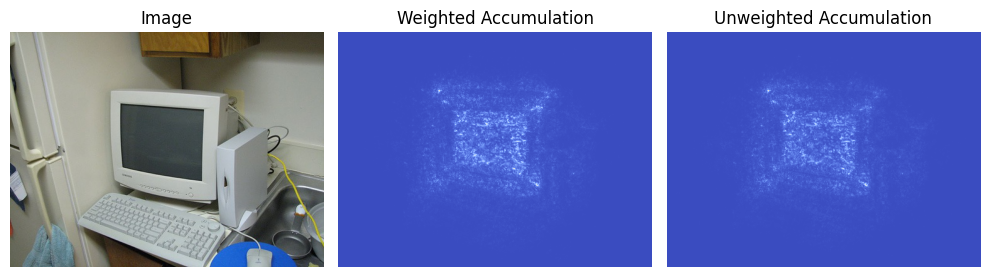

100%|██████████| 1464/1464 [00:46<00:00, 31.55it/s]


In [28]:
for iter, pack in enumerate(tqdm(data_loader)):
    if iter==1:
        
        img_name = pack['name'][0]


        label = pack['label'][0]

        target_class = torch.nonzero(label)[:, 0]
        number_classes = int(label.sum().item())
        
        input_img = pack['img'][0][0:1, ...]
        
        gt_label = gt_labels[iter]
        # print(gt_label.shape)
        # plt.imshow(gt_label)
        # print(input_img.shape)
        
        with torch.autocast(device_type = 'cuda', dtype = torch.float16):
           

            w_accumulated_saliency = get_saliencies(img_tensor=input_img,
                                      target_class=target_class,
                                      input_fmt='w_crop_accumulate',num_crops=NUM_CROPS,
                                      num_masks=NUM_MASKS)
            
            unw_accumulated_saliency = get_saliencies(img_tensor=input_img,
                                      target_class=target_class,
                                      input_fmt='uw_crop_accumulate',num_crops=NUM_CROPS,
                                      num_masks=NUM_MASKS)
       

            

        fig, ax = plt.subplots(1, 3, figsize=(10, 3),dpi=100)


        ax[0].imshow(unnormalize_image(input_img))
        ax[0].axis('off')
        ax[0].set_title('Image')

        ax[1].imshow(w_accumulated_saliency.detach().cpu().numpy()[0], cmap="coolwarm")
        ax[1].axis('off')
        ax[1].set_title('Weighted Accumulation')

        ax[2].imshow(unw_accumulated_saliency.detach().cpu().numpy()[0], cmap="coolwarm")
        ax[2].axis('off')
        ax[2].set_title('Unweighted Accumulation')


        # plt.savefig(img_name+'_'+str(idx)+'_'+str(NUM_CROPS)+'_l2.png')
        fig.tight_layout()
        plt.show()


        


## Saving Saliencies

In [13]:
for iter, pack in enumerate(tqdm(data_loader)):
        
    img_name = pack['name'][0]
    
    if os.path.exists(os.path.join(SALIENCY_DIR, img_name+'.npy')):
        continue

    label = pack['label'][0]
    
    target_class = torch.nonzero(label)[:, 0]
    
    input_img = pack['img'][0][0:1, ...]
    
    with torch.autocast(device_type = 'cuda', dtype = torch.float16):
        
        w_accumulated_saliency = get_saliencies(img_tensor=input_img,
                                      target_class=target_class,
                                      input_fmt='w_crop_accumulate',num_crops=NUM_CROPS,
                                      num_masks=NUM_MASKS)
            
        unw_accumulated_saliency = get_saliencies(img_tensor=input_img,
                                      target_class=target_class,
                                      input_fmt='uw_crop_accumulate',num_crops=NUM_CROPS,
                                      num_masks=NUM_MASKS)
        


        #Saving weighted saliencies
        np.save(os.path.join(SALIENCY_DIR+'weighted/', img_name+'.npy'),{'saliency':w_accumulated_saliency.cpu().numpy(), 'cls_label': target_class})

        #Saving unweighted saliencies
        np.save(os.path.join(SALIENCY_DIR+'unweighted/', img_name+'.npy'),{'saliency':unw_accumulated_saliency.cpu().numpy(),'cls_label': target_class})
                                                                                                                                                
                                                                                    


100%|██████████| 1464/1464 [1:50:26<00:00,  4.53s/it] 


In [26]:
# len(global_coordinates)

In [141]:
# global_coordinates

### Writing the list to a file 

In [15]:
# with open(r'glob_coordinates.txt', 'w') as fp:
#     for item in global_coordinates:
#         for word in item:
#             fp.write("%s,"%word)
#         # write each item on a new line
#         fp.write("\n")
#     print('Done')

Done


### Reading list from the file

In [28]:
# g_coordinates = []

In [27]:
# i = 0
# with open(r'glob_coordinates.txt', 'r') as fp:
#     for line in fp:
#         # remove linebreak from a current name
#         temp = []
#         x = line[:-1]
#         x = x.split(",")
        
#         for i in range(4):
#             temp.append(int(x[i]))
            
#         g_coordinates.append(temp)

In [29]:
# len(g_coordinates)

In [142]:
# g_coordinates

## Processing Functions

In [8]:
def smooth(input_saliency):
    '''
    tensor -> tensor
    input_saliency.shape = Num_class, H, W
    output_saliency.shape = Num_class, H, W
    
    '''
    
    input_saliency = input_saliency.unsqueeze(1)
    
    kernel_size, sigma = 13, 5
    
    axis = torch.linspace(-(kernel_size-1)/2., 
                          -(kernel_size-1)/2., 
                          kernel_size)
    gaussian = torch.exp(- 0.5 * axis**2 / sigma**2)
    
    kernel = torch.outer(gaussian, gaussian)[None, None, :, :]
    
    output_saliency = F.conv2d(input_saliency, kernel, padding=kernel_size//2)
    
    return output_saliency.squeeze(1)


In [9]:
def normalization(input_saliency):
    '''
    tensor -> tensor
    input_saliency.shape = Num_class, H, W
    output_saliency.shape = Num_class, H, W
    
    '''
    N_CLASS, H, W = input_saliency.shape
    
    input_saliency = input_saliency.unsqueeze(1)
    
    min_ = input_saliency.view(N_CLASS, -1).min(-1)[0]
    min_ = min_[:, None, None, None].repeat(1, 1, H, W)
    
    max_ = torch.quantile(input = input_saliency.view(N_CLASS,-1), 
                          q = 0.995, 
                          dim=-1, keepdim=False, 
                          interpolation="nearest", out=None)
    max_ = max_[:, None, None, None].repeat(1, 1, H, W)
    
    saliency = torch.clamp(input_saliency, max=max_)
    saliency_normalized = (saliency - min_)/(max_ - min_)
    
    return saliency_normalized.squeeze(1)

In [10]:
def subtraction(input_saliency, weights=[1.5, 0.5]):
    '''
    tensor -> tensor
    input_saliency.shape = Num_class, H, W
    output_saliency.shape = Num_class, H, W
    
    '''
    # print(input_saliency.shape)
    N_CLASS, H, W = input_saliency.shape
    
    input_saliency = input_saliency.unsqueeze(1)
    
    sub_tensor = -1*weights[1]*torch.ones(N_CLASS, N_CLASS) + weights[0]*torch.eye(N_CLASS)
    
    out_saliency = F.relu(torch.einsum("ij,jklm->iklm",
                                       sub_tensor, 
                                       input_saliency))
    return out_saliency.squeeze(1)

In [11]:
def resolve_background(input_saliency, cls_label, thres=0.3):
    '''
    tensor -> ndarray
    input_saliency.shape = Num_class, H, W
    cls_label = sal_obj['cls_label']
    predicted_saliency.shape = H, W
    '''
    # print(input_saliency.shape)
    saliency = subtraction(input_saliency)
    saliency_ndarray = normalization(saliency).cpu().numpy()
    
    saliency_bg = np.pad(saliency_ndarray, 
                  ((1, 0), (0, 0), (0, 0)), 
                  mode='constant', 
                  constant_values=thres)
    
    keys = np.pad(cls_label + 1, 
                  (1, 0), 
                  mode='constant')
    
    cls_labels = np.argmax(saliency_bg, axis=0)
        
    predicted_saliency = keys[cls_labels]
    
    return predicted_saliency

In [12]:
def super_pixel_prediction(input_saliency, img_name, thres=0.1, fmt='absolute'):
    '''
    tensor -> ndarray
    input_saliency.shape = Num_class, H, W
    predicted_class.shape = H, W
    '''
    saliency_ndarray = input_saliency.cpu().numpy()
    
    N_CLASS, H, W = input_saliency.shape
    
    sp_onehot_mask = np.load(f"/data/voc12/superpixel/masks/{img_name}.npy")
    
    predicted_mask = [np.zeros_like(saliency_ndarray[0])+1e-8]
    
    for idx in range(N_CLASS):
        
        saliency = saliency_ndarray[idx]
        scattered_saliency = sp_onehot_mask * saliency[None, :, :]
        sp_score = scattered_saliency.sum((1, 2))/sp_onehot_mask.sum((1, 2))
        
        if fmt=='absolute':
            selected_mask = sp_score > thres
            
        else:
            selected_mask = sp_score > (thres * sp_score.mean())
            
        aggregated_saliency = scattered_saliency[selected_mask].sum(0)
        
        predicted_mask.append(aggregated_saliency)
        
    predicted_class = np.stack(predicted_mask).argmax(0)
    
    return predicted_class
            

In [13]:
def get_predictions(thres=0.25, smoothing=False, superpixel=False):
    
    w_preds = []
    uw_preds = []
    
    for id in tqdm(gt_dataset.ids):
        
        w_sal_obj = np.load(os.path.join(SALIENCY_DIR+'weighted/', id + '.npy'), allow_pickle=True).item()
        uw_sal_obj = np.load(os.path.join(SALIENCY_DIR+'unweighted/', id + '.npy'), allow_pickle=True).item()
        
        
        w_saliency = w_sal_obj['saliency']
        uw_saliency = uw_sal_obj['saliency']
    
        cls_label = w_sal_obj['cls_label']
        
        img_name = id
        
        keys = np.pad(cls_label + 1, 
                      (1, 0), 
                      mode='constant')
        
        w_saliency_tensor = torch.tensor(w_saliency)
        uw_saliency_tensor = torch.tensor(uw_saliency)
        
        if smoothing:
            
            w_saliency_tensor = smooth(w_saliency_tensor)
            
            w_saliency_tensor = normalization(w_saliency_tensor)
            
            #Unweighted
            uw_saliency_tensor = smooth(uw_saliency_tensor)
            
            uw_saliency_tensor = normalization(uw_saliency_tensor)
            
        if superpixel:
            
            w_saliency_tensor = subtraction(w_saliency_tensor)
            
            w_saliency_tensor = normalization(w_saliency_tensor)
            
            cls_labels = super_pixel_prediction(w_saliency_tensor, 
                                                img_name, 
                                                thres=thres, 
                                                fmt='absolute')
            cls_labels = keys[cls_labels]
            
            w_preds.append(cls_labels.copy())
            
            #Unweighted
            uw_saliency_tensor = subtraction(uw_saliency_tensor)
            
            uw_saliency_tensor = normalization(uw_saliency_tensor)
            
            cls_labels = super_pixel_prediction(uw_saliency_tensor, 
                                                img_name, 
                                                thres=thres, 
                                                fmt='absolute')
            cls_labels = keys[cls_labels]
            
            uw_preds.append(cls_labels.copy())
            
        else:
            w_cls_labels = resolve_background(w_saliency_tensor, 
                                            cls_label, 
                                            thres=thres)
            w_preds.append(w_cls_labels.copy())
            
            #Unweighted
            uw_cls_labels = resolve_background(uw_saliency_tensor, 
                                            cls_label, 
                                            thres=thres)
            uw_preds.append(uw_cls_labels.copy())
        
    return w_preds,uw_preds

In [14]:
def viz_first_n_saliencies(options, n=1, thres=0.25):
    
    for iter, pack in enumerate(data_loader):
        
        img_name = pack['name'][0]
        
        input_img = pack['img'][0][0:1, ...]
        
        w_sal_obj = np.load(os.path.join(SALIENCY_DIR+'weighted/', img_name + '.npy'), allow_pickle=True).item()
        uw_sal_obj = np.load(os.path.join(SALIENCY_DIR+'unweighted/', img_name + '.npy'), allow_pickle=True).item()
        
        w_saliency = w_sal_obj['saliency']
        uw_saliency = uw_sal_obj['saliency']
    
        cls_label = w_sal_obj['cls_label']
        
        keys = np.pad(cls_label + 1, 
                      (1, 0), 
                      mode='constant')
        
        w_saliency_tensor = torch.tensor(w_saliency)
        uw_saliency_tensor = torch.tensor(uw_saliency)
        
        w_preds = []
        uw_preds = []
        
        if options['smoothing']:
            
            w_saliency_tensor = smooth(w_saliency_tensor)
            
            w_saliency_tensor = normalization(w_saliency_tensor)
            
            #Unweighted
            uw_saliency_tensor = smooth(uw_saliency_tensor)
            
            uw_saliency_tensor = normalization(uw_saliency_tensor)
            
        if options['superpixel']:
            
            w_saliency_tensor = subtraction(w_saliency_tensor)
            
            w_saliency_tensor = normalization(w_saliency_tensor)
            
            cls_labels = super_pixel_prediction(w_saliency_tensor, 
                                                img_name, 
                                                thres=thres, 
                                                fmt='absolute')
            cls_labels = keys[cls_labels]
            
            w_preds.append(cls_labels.copy())
            
            #Unweighted
            uw_saliency_tensor = subtraction(uw_saliency_tensor)
            
            uw_saliency_tensor = normalization(uw_saliency_tensor)
            
            cls_labels = super_pixel_prediction(uw_saliency_tensor, 
                                                img_name, 
                                                thres=thres, 
                                                fmt='absolute')
            cls_labels = keys[cls_labels]
            
            uw_preds.append(cls_labels.copy())
            
        else:
            w_cls_labels = resolve_background(w_saliency_tensor, 
                                            cls_label, 
                                            thres=thres)
            w_preds.append(w_cls_labels.copy())
            
            #Unweighted
            uw_cls_labels = resolve_background(uw_saliency_tensor, 
                                            cls_label, 
                                            thres=thres)
            uw_preds.append(uw_cls_labels.copy())
            
            
        # print(input_img.shape)
        
        w_predicted_saliency = w_preds[0]
        uw_predicted_saliency = uw_preds[0]
        gt_label = gt_labels[iter]
        ndr_gt_label = ndr_gt_labels[iter]
        
        fig, ax = plt.subplots(1, 3, figsize=(12, 3))
        ax[0].imshow(myutils.unnormalize_image(input_img))
        ax[0].axis('off')
        ax[0].set_title('Image')
        sns.heatmap(w_predicted_saliency, vmax='20', cmap='tab20', ax=ax[1])
        ax[1].axis('off')
        ax[1].set_title('iou:{:.2f}\nWeighted Accumulation'.format(compute_miou([w_predicted_saliency], [gt_label])))
        sns.heatmap(uw_predicted_saliency, vmax='20', cmap='tab20', ax=ax[2])
        ax[2].axis('off')
        ax[2].set_title('iou:{:.2f}\nUnweighted Accumulation'.format(compute_miou([uw_predicted_saliency], [gt_label])))
        # plt.savefig('vis_'+str(count)+'.png')
        plt.show()
        
        if iter+1 == n:
            break
        
   

### mIOU Function

In [16]:
from chainercv.evaluations import calc_semantic_segmentation_confusion

def compute_miou(preds, gts):
    
    confusion = calc_semantic_segmentation_confusion(preds, gts)

    gtj = confusion.sum(axis=1)
    resj = confusion.sum(axis=0)
    gtjresj = np.diag(confusion)
    denominator = gtj + resj - gtjresj
    iou = gtjresj / denominator

    return np.nanmean(iou)

### Visualization

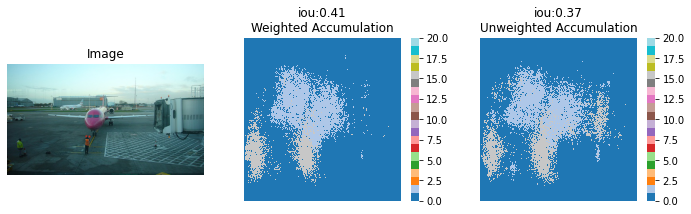

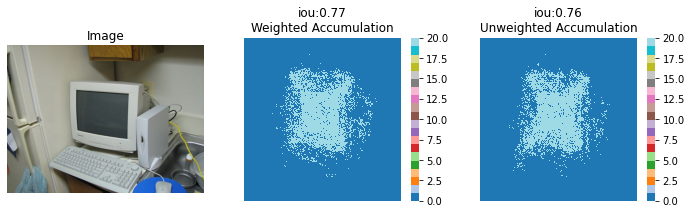

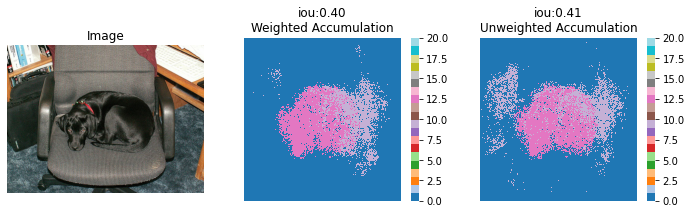

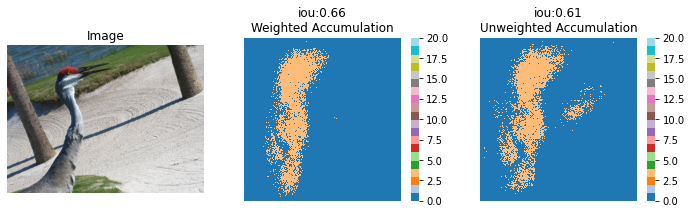

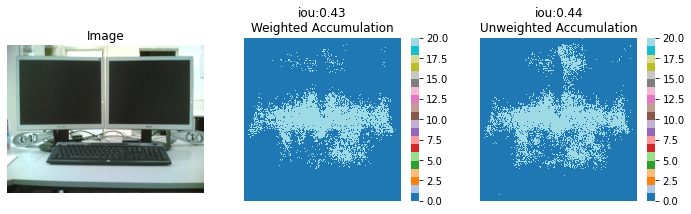

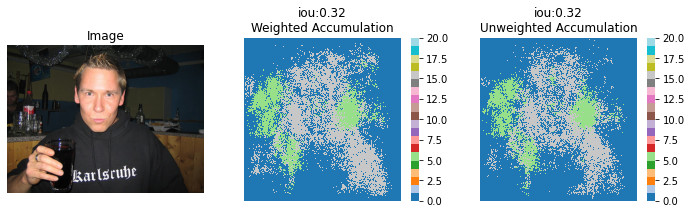

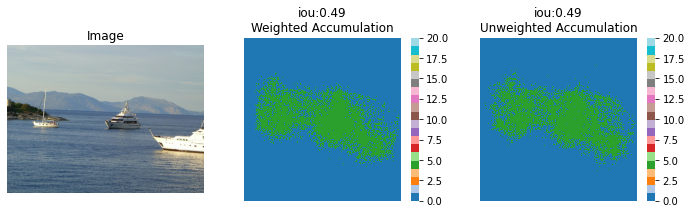

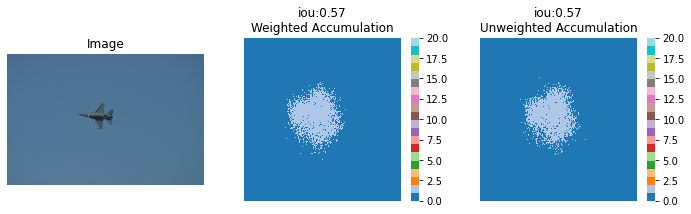

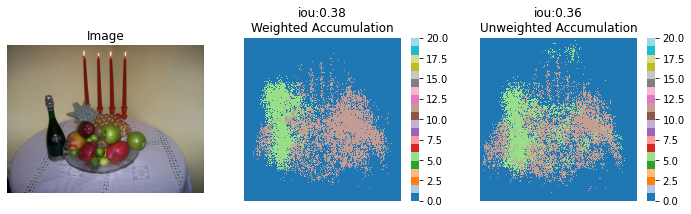

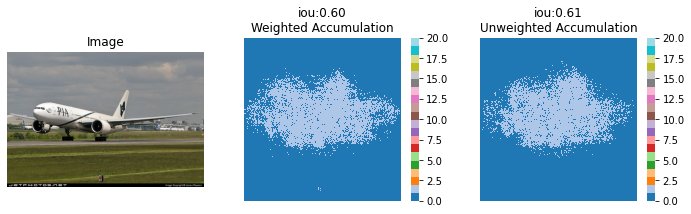

In [17]:
options = {
    'smoothing': False,
    'superpixel': False,
}

viz_first_n_saliencies(options, n = 10, thres=0.1)

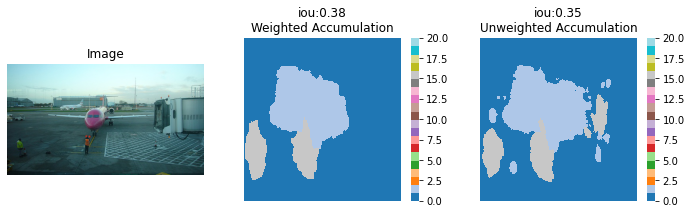

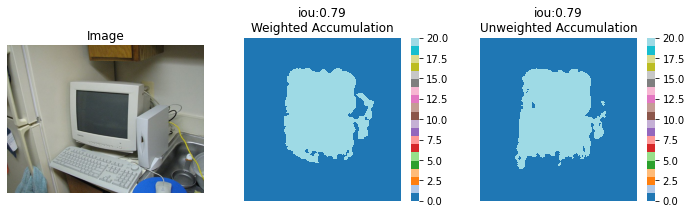

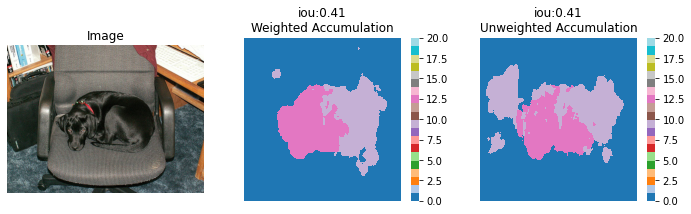

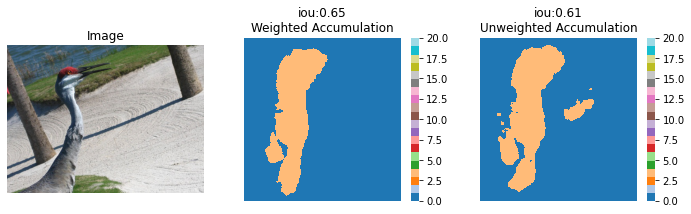

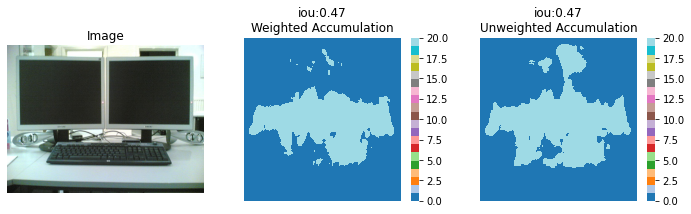

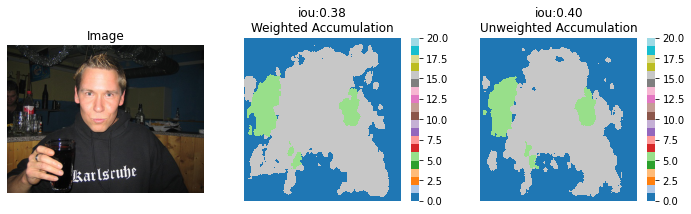

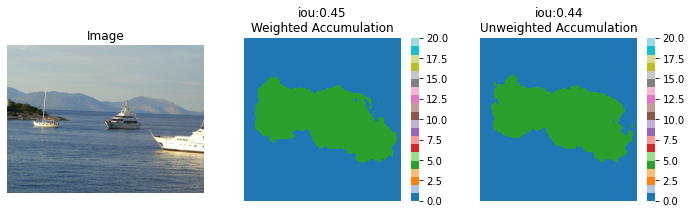

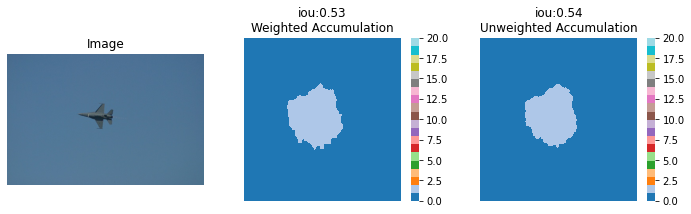

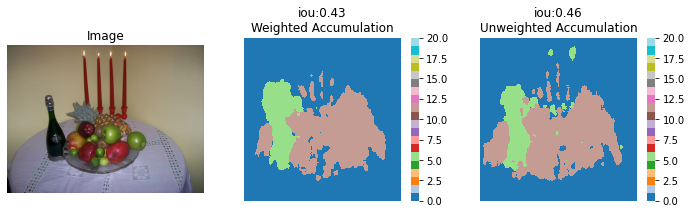

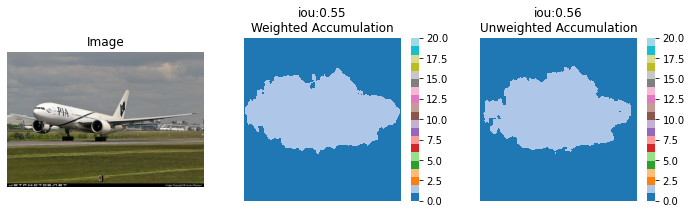

In [18]:
options = {
    'smoothing': True,
    'superpixel': False,
}

viz_first_n_saliencies(options, n = 10, thres=0.1)

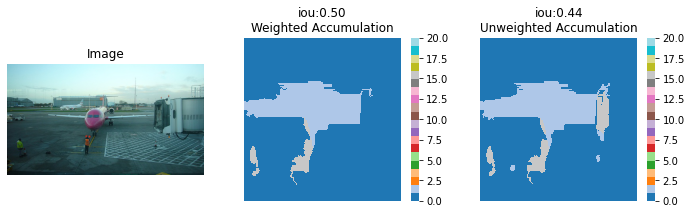

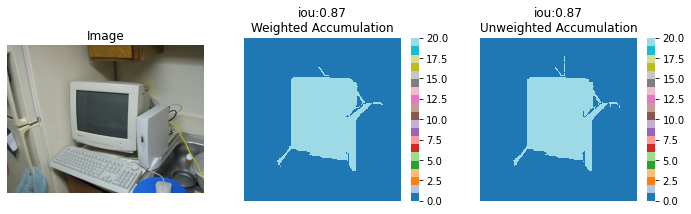

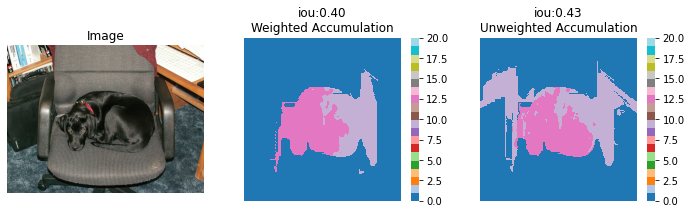

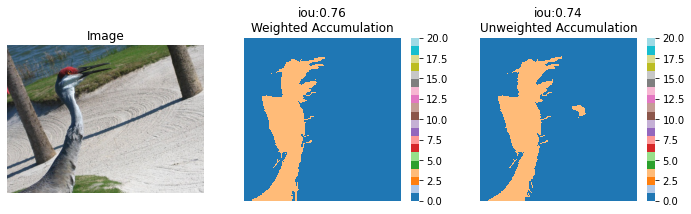

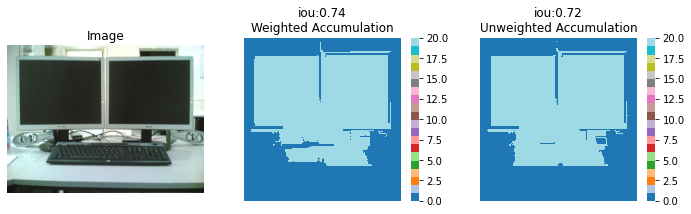

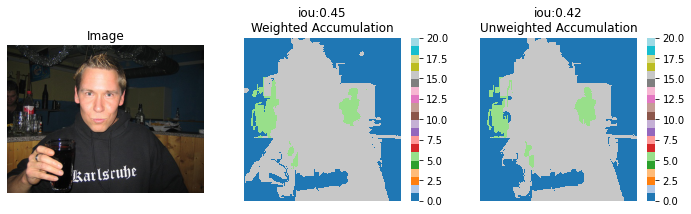

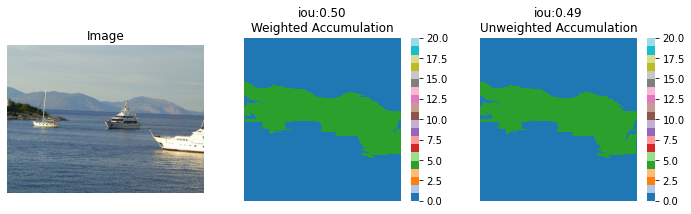

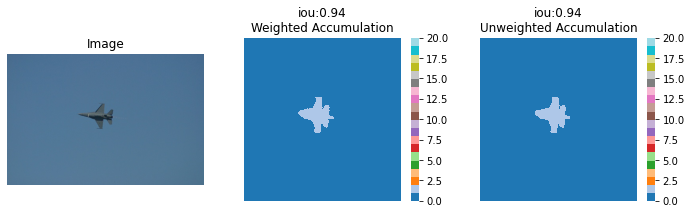

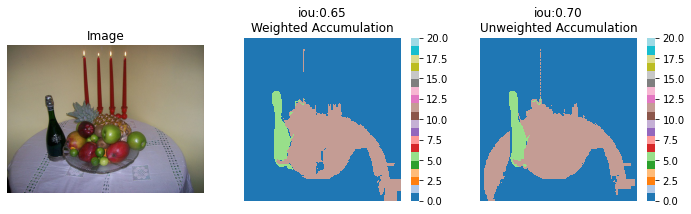

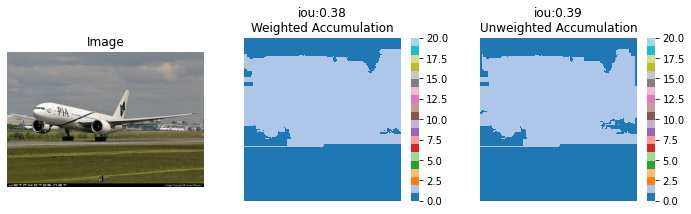

In [19]:
options = {
    'smoothing': True,
    'superpixel': True,
}

viz_first_n_saliencies(options, n = 10, thres=0.1)

## mIOU for Different Thresholds

In [30]:
w_preds,uw_preds = get_predictions(thres=0.1, smoothing=False, superpixel=False)

100%|██████████| 1464/1464 [02:39<00:00,  9.17it/s]


In [35]:
type(w_preds[0])

numpy.ndarray

In [20]:
# Ground truths are in gt_labels
# NDR GTs are in ndr_gt_labels

sm_n_sp_n_thresholds = [round(i, 2) for i in np.arange(0.04, 0.35, .02)]

print(f'\n{"".join(["#" for i in range(60)])}')
print('SMOOTHING: False, SUPERPIXEL: False')
print(f'{"".join(["#" for i in range(60)])}\n')

weight_miou = []
uweight_miou = []
w_ndrmiou = []
uw_ndrmiou = []

for thres in sm_n_sp_n_thresholds:
    w_preds,uw_preds = get_predictions(thres=thres, smoothing=False, superpixel=False)
    w_miou = compute_miou(w_preds, gt_labels)
    uw_miou = compute_miou(uw_preds, gt_labels)
    
    weight_miou.append(w_miou)
    uweight_miou.append(uw_miou)
    
    w_ndr_miou = compute_miou(w_preds, ndr_gt_labels)
    uw_ndr_miou = compute_miou(uw_preds, ndr_gt_labels)
    
    w_ndrmiou.append(w_ndr_miou)
    uw_ndrmiou.append(uw_ndr_miou)
    
    print(f'\n Weighted mIoU for {thres}: {w_miou}\n Weighted NDR-mIoU for {thres}: {w_ndr_miou}\n\n')
    print(f'\n Unweighted mIoU for {thres}: {uw_miou}\n Unweighted NDR-mIoU for {thres}: {uw_ndr_miou}\n\n')


############################################################
SMOOTHING: False, SUPERPIXEL: False
############################################################



100%|██████████| 1464/1464 [02:29<00:00,  9.78it/s]



 Weighted mIoU for 0.04: 0.4298622459485773
 Weighted NDR-mIoU for 0.04: 0.5574233845533547



 Unweighted mIoU for 0.04: 0.40073596881004936
 Unweighted NDR-mIoU for 0.04: 0.5534400038896671




100%|██████████| 1464/1464 [02:28<00:00,  9.83it/s]



 Weighted mIoU for 0.06: 0.42953053616841125
 Weighted NDR-mIoU for 0.06: 0.47954303986399877



 Unweighted mIoU for 0.06: 0.40492035967859
 Unweighted NDR-mIoU for 0.06: 0.47854154699757145




100%|██████████| 1464/1464 [02:31<00:00,  9.69it/s]



 Weighted mIoU for 0.08: 0.4166936405927403
 Weighted NDR-mIoU for 0.08: 0.4152986268854385



 Unweighted mIoU for 0.08: 0.39601774688250074
 Unweighted NDR-mIoU for 0.08: 0.4162165459980721




100%|██████████| 1464/1464 [02:31<00:00,  9.65it/s]



 Weighted mIoU for 0.1: 0.3980183561125128
 Weighted NDR-mIoU for 0.1: 0.3617584055071288



 Unweighted mIoU for 0.1: 0.3805349429066674
 Unweighted NDR-mIoU for 0.1: 0.36376079985260745




100%|██████████| 1464/1464 [02:36<00:00,  9.38it/s]



 Weighted mIoU for 0.12: 0.37685282579965673
 Weighted NDR-mIoU for 0.12: 0.3167549895977582



 Unweighted mIoU for 0.12: 0.3619192361780558
 Unweighted NDR-mIoU for 0.12: 0.319462244764832




100%|██████████| 1464/1464 [02:30<00:00,  9.70it/s]



 Weighted mIoU for 0.14: 0.35482753856848237
 Weighted NDR-mIoU for 0.14: 0.2785765907124905



 Unweighted mIoU for 0.14: 0.3420336683089611
 Unweighted NDR-mIoU for 0.14: 0.2817712580206855




100%|██████████| 1464/1464 [02:27<00:00,  9.92it/s]



 Weighted mIoU for 0.16: 0.3330920902695714
 Weighted NDR-mIoU for 0.16: 0.24610804195121289



 Unweighted mIoU for 0.16: 0.32198753585494844
 Unweighted NDR-mIoU for 0.16: 0.24949671487321648




100%|██████████| 1464/1464 [02:24<00:00, 10.16it/s]



 Weighted mIoU for 0.18: 0.312103061697018
 Weighted NDR-mIoU for 0.18: 0.2182925656342504



 Unweighted mIoU for 0.18: 0.3023692251716036
 Unweighted NDR-mIoU for 0.18: 0.2217262304695946




100%|██████████| 1464/1464 [02:24<00:00, 10.14it/s]



 Weighted mIoU for 0.2: 0.29221530735171825
 Weighted NDR-mIoU for 0.2: 0.19437959754210238



 Unweighted mIoU for 0.2: 0.28358440879443986
 Unweighted NDR-mIoU for 0.2: 0.19773153147899641




100%|██████████| 1464/1464 [02:34<00:00,  9.47it/s]



 Weighted mIoU for 0.22: 0.2735193038595897
 Weighted NDR-mIoU for 0.22: 0.17364432495747442



 Unweighted mIoU for 0.22: 0.26583987477579435
 Unweighted NDR-mIoU for 0.22: 0.17686809257014297




100%|██████████| 1464/1464 [02:33<00:00,  9.57it/s]



 Weighted mIoU for 0.24: 0.25607926415192594
 Weighted NDR-mIoU for 0.24: 0.15557922367954022



 Unweighted mIoU for 0.24: 0.24914808400160615
 Unweighted NDR-mIoU for 0.24: 0.15870816610106903




100%|██████████| 1464/1464 [02:43<00:00,  8.97it/s]



 Weighted mIoU for 0.26: 0.23984094166567801
 Weighted NDR-mIoU for 0.26: 0.1397754402243423



 Unweighted mIoU for 0.26: 0.23361769545250616
 Unweighted NDR-mIoU for 0.26: 0.14283120853558973




100%|██████████| 1464/1464 [02:32<00:00,  9.60it/s]



 Weighted mIoU for 0.28: 0.22486012726919893
 Weighted NDR-mIoU for 0.28: 0.12596529409816265



 Unweighted mIoU for 0.28: 0.21917180934221878
 Unweighted NDR-mIoU for 0.28: 0.12884233214075605




100%|██████████| 1464/1464 [02:46<00:00,  8.81it/s]



 Weighted mIoU for 0.3: 0.21103503304210636
 Weighted NDR-mIoU for 0.3: 0.11382143710397459



 Unweighted mIoU for 0.3: 0.2058111128450657
 Unweighted NDR-mIoU for 0.3: 0.11653678729815663




100%|██████████| 1464/1464 [02:33<00:00,  9.56it/s]



 Weighted mIoU for 0.32: 0.19827367681322408
 Weighted NDR-mIoU for 0.32: 0.10307893430278489



 Unweighted mIoU for 0.32: 0.19344926889187053
 Unweighted NDR-mIoU for 0.32: 0.10562224742024745




100%|██████████| 1464/1464 [02:32<00:00,  9.58it/s]



 Weighted mIoU for 0.34: 0.1865392601979167
 Weighted NDR-mIoU for 0.34: 0.09356790476831064



 Unweighted mIoU for 0.34: 0.18206567686589592
 Unweighted NDR-mIoU for 0.34: 0.09594018437523126


